In [79]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, make_scorer, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [80]:
data = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

In [81]:
data.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Checking data for missing values

In [82]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

There is no missing data in the entire dataset.

# Data Exploration

### Transaction in time

In [83]:
class_0 = data.loc[data['Class'] == 0]['Time']
class_1 = data.loc[data['Class'] == 1]['Time']
hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']
fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only')

Fraud transactions have more even distribution than non-fraud transactions

Mean of fraud transactions vs non-fraud transactions

In [84]:
nonFraud = data.loc[data['Class'] == 0]['Amount']
fraud = data.loc[data['Class'] == 1]['Amount']

In [85]:
nonFraud.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [86]:
fraud.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

We can see that fraud transactions have higher mean than non-fraud transactions.

### Features Correlation

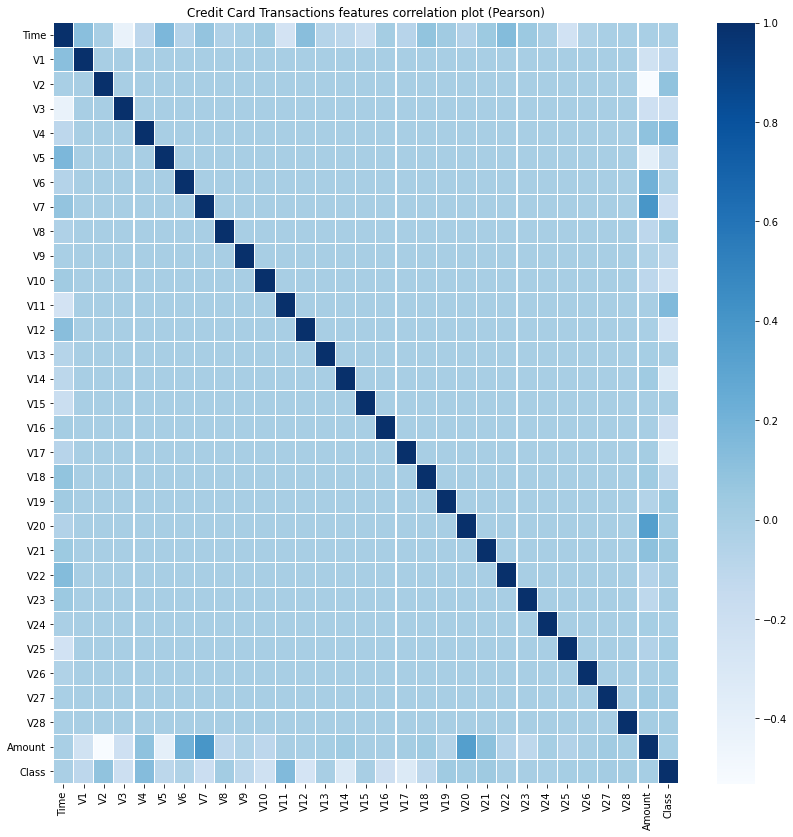

In [87]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = data.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Blues")
plt.show()

There is no significant correlation bewteen features. There is certain correlations between some features. 

Amount -> direct correlation with V7 and V20 and inverse correlation with V2 and V5.

Time -> inverse correlation with V3.


# Handling dataset imbalance

Used Random Under sampler to handle the class imbalance. Under sampled the majority class.

In [88]:
no_of_fraud_samples = len(data[data['Class'] == 1])
no_of_nonfraud_samples = len(data[data['Class'] == 0])
print('Number of fraud samples: {}'.format(no_of_fraud_samples))
print('Number of non-fraud samples: {}'.format(no_of_nonfraud_samples))

Number of fraud samples: 492
Number of non-fraud samples: 284315


In [89]:
rus = RandomUnderSampler(random_state=42)
y = data['Class']
X = data.drop('Class', axis =1)
X_res, y_res = rus.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 492, 1: 492})


## Predictive Models

Here we'll try to find best model among logistic regression, random forest, AdaBoost and XGBoost classifier. The metrics we are using to find the best model is F1 score as it considers both precision and recall. If we have not balanced the dataset we would have used hamming loss as it handles class imbalance by assigning equal weight to each label.

Instead of using a regular hold-out strategy (train_test_split) we'll using cross_validation to train and test our model.

In [90]:
def cross_val(model, cv=3):
    scores = cross_validate(model, X_res, y_res, cv=cv,
                            scoring= make_scorer(f1_score),
                            return_train_score = True)
    avg_score = np.mean(scores['test_score'])
    print(avg_score)

### Logistic Regression 

In [91]:
lr = LogisticRegression(random_state =0)
cross_val(lr)

0.9190064542410005


### Random Forest Classifer

In [92]:
clf = RandomForestClassifier(n_jobs=-1, random_state=0)
cross_val(clf)

0.9231854838709678


Let's visulaize the important features

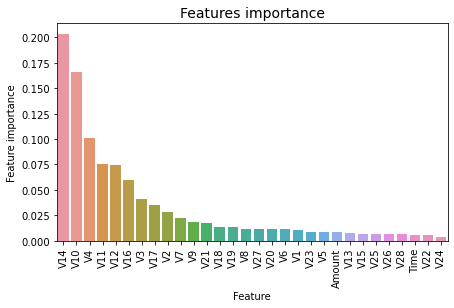

In [93]:
clf = RandomForestClassifier(n_jobs=-1, random_state=0).fit(X_res, y_res)
tmp = pd.DataFrame({'Feature': X_res.columns, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

The most important features are: V14, V10, V4, V11, V12 and V16.

### AdaBoost

In [94]:
ad = AdaBoostClassifier(n_estimators = 100, learning_rate = 0.8,
                        random_state=0)
cross_val(ad)

0.506707729855878


Let's visulaize the important features

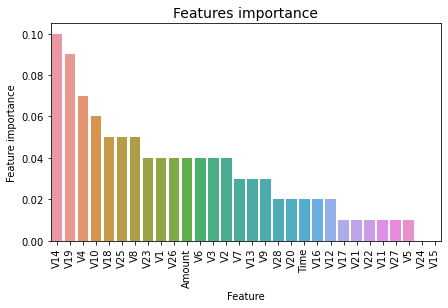

In [95]:
clf = AdaBoostClassifier(n_estimators = 100, learning_rate = 0.8, 
                         random_state=0).fit(X_res, y_res)
tmp = pd.DataFrame({'Feature': X_res.columns, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

The important features are: V14, V19, V4, V10 and V18.

### XGBoost

In [96]:
xg = GradientBoostingClassifier(learning_rate = 0.8, n_estimators = 70, 
                                random_state=0)
cross_val(xg)

0.8923161878811574


Let's visualize the important features

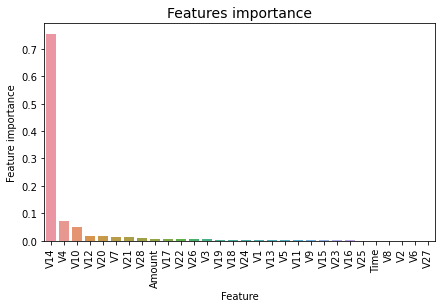

In [97]:
clf = GradientBoostingClassifier(learning_rate = 0.8, n_estimators = 70, 
                                 random_state=0).fit(X_res, y_res)
tmp = pd.DataFrame({'Feature': X_res.columns, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

## Conclusion

Here, I explored the data, checked for missing values, visualized the features and understood the relationship between different features. I checked for data imbalance and found that the fraud transactions were only ~0.17% when compared to non-fraudulent transactions.

I have used cross-validation to evaluate the different models and used f1-score as the scoring criterion. I used different predictive models such as Logistic Regression, Random Forest, AdaBoost and XGBoost. Out of all the models Random forest had the best F1-score ~ **0.92**.

## References

[1] https://www.kaggle.com/gpreda/credit-card-fraud-detection-predictive-models
